In [1]:
import pandas as pd
from pathlib import Path
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
import torchvision
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from sklearn.metrics import confusion_matrix
import numpy as np
import sklearn.metrics as metrics
from torch.utils.data import Subset
from torchcontrib.optim import SWA

In [2]:
Catholic_file = 'aug_train_v2.2.csv'
df = pd.read_csv(Catholic_file)
df

,filename,category,class,sex,old
0,0002-1.wav,non-wheezing,0,1,7
1,0002-2.wav,non-wheezing,0,1,7
2,0002-3.wav,non-wheezing,0,1,7
3,0002-4.wav,non-wheezing,0,1,7
4,0003-2.wav,non-wheezing,0,0,1
...,...,...,...,...,...
1605,wn_0535-4.wav,wheezing,1,0,9
1606,wn_0588-1.wav,wheezing,1,0,1
1607,wn_0599-3.wav,wheezing,1,1,6
1608,wn_0602-2.wav,wheezing,1,1,8


In [3]:
df = df.sample(frac=1)

In [4]:
df

,filename,category,class,sex,old
1362,ts_0613-3.wav,wheezing,1,0,1
1470,wn_0034-4.wav,non-wheezing,0,1,2
1175,ts_0011-2.wav,non-wheezing,0,1,0
299,cp_0028-3.wav,non-wheezing,0,1,3
1312,ts_0515-1.wav,wheezing,1,1,9
...,...,...,...,...,...
1139,rs_0070-1.wav,wheezing,1,1,8
1110,rs_0590-4.wav,wheezing,1,1,2
1492,wn_0041-3.wav,non-wheezing,0,0,2
1444,wn_0026-4.wav,non-wheezing,0,0,7


In [5]:
mean = df.old.mean()
std = df.old.std()
df.old = (df.old - mean) / std

In [6]:
df

,filename,category,class,sex,old
1362,ts_0613-3.wav,wheezing,1,0,-0.948195
1470,wn_0034-4.wav,non-wheezing,0,1,-0.639293
1175,ts_0011-2.wav,non-wheezing,0,1,-1.257097
299,cp_0028-3.wav,non-wheezing,0,1,-0.330391
1312,ts_0515-1.wav,wheezing,1,1,1.523021
...,...,...,...,...,...
1139,rs_0070-1.wav,wheezing,1,1,1.214119
1110,rs_0590-4.wav,wheezing,1,1,-0.639293
1492,wn_0041-3.wav,non-wheezing,0,0,-0.639293
1444,wn_0026-4.wav,non-wheezing,0,0,0.905217


In [7]:
df['relative_path'] = '/' + df['filename'].astype(str)
df = df[['relative_path', 'class', 'sex', 'old']]
df.head()

,relative_path,class,sex,old
1362,/ts_0613-3.wav,1,0,-0.948195
1470,/wn_0034-4.wav,0,1,-0.639293
1175,/ts_0011-2.wav,0,1,-1.257097
299,/cp_0028-3.wav,0,1,-0.330391
1312,/ts_0515-1.wav,1,1,1.523021


In [8]:
data_path = 'aug_train_v2.2'

In [9]:
class Breath_sound_Util():
  
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    
    return (sig, sr)

  def resample(aud, newsr):
    sig, sr = aud
    
    if (sr == newsr):
     return aud

    num_channels = sig.shape[0]
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))
  

  def pad(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms
   
    if (sig_len > max_len):
      sig = sig[:,:max_len]
 
    elif (sig_len < max_len):

      repeated = []
      repeated.append(sig)
      required_len = max_len - sig_len

      while required_len > sig_len : 
        repeated.append(sig)
        require_len -= sig_len
      repeated.append(sig[:, :required_len])
 
      sig = torch.cat(repeated, 1)

    return (sig, sr)


  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80
    
    spec = torchaudio.transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
    spec = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = torchaudio.transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = torchaudio.transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec
    print(aug_spec)

In [10]:
class breathDS(Dataset):
    
  def __init__(self, df, data_path):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 4000
    self.sr = 22050
            
  def __len__(self):
    return len(self.df)    
    
  def __getitem__(self, idx):
    audio_file = self.data_path + self.df.loc[idx, 'relative_path']
    class_id = self.df.loc[idx, 'class']
    
    aud = Breath_sound_Util.open(audio_file)
    reaud = Breath_sound_Util.resample(aud, self.sr)
    dur_aud = Breath_sound_Util.pad(reaud, self.duration)
    sgram = Breath_sound_Util.spectro_gram(dur_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = Breath_sound_Util.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
    #print(aug_sgram.size())
    aug_sgram = aug_sgram.squeeze()
    aug_sgram = torch.transpose(aug_sgram, 0, 1)
    #print(aug_sgram.size())
    #여기부터 나이, 성별변수를 집어넣는 과정임
    x = self.df.loc[idx, 'old']
    y = self.df.loc[idx, 'sex']
    x = torch.from_numpy(np.asarray(x).reshape((1,)))
    y = torch.from_numpy(np.asarray(y).reshape((1,)))
    tabular = torch.cat((x, y), 0)
    tabular = tabular.float()
    #print(tabular)
    #x1 = ["sex", "old"]
    #x2 = x2.
    #x2 = x2.iloc[idx].values
    #aug_sgram = torch.cat((sgram, aug_sgram), 0)
    
    
    return aug_sgram, tabular, class_id

In [11]:
brds = breathDS(df, data_path)

In [12]:
train_dl = DataLoader(brds, batch_size=32, shuffle=True)

In [13]:
'''def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)

        self.ca = ChannelAttention(planes * 4)
        self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out = self.ca(out) * out
        out = self.sa(out) * out

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out'''

'''class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.ca(out) * out
        out = self.sa(out) * out

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out'''

'class BasicBlock(nn.Module):\n    expansion = 1\n\n    def __init__(self, inplanes, planes, stride=1, downsample=None):\n        super(BasicBlock, self).__init__()\n        self.conv1 = conv3x3(inplanes, planes, stride)\n        self.bn1 = nn.BatchNorm2d(planes)\n        self.relu = nn.ReLU(inplace=True)\n        self.conv2 = conv3x3(planes, planes)\n        self.bn2 = nn.BatchNorm2d(planes)\n\n        self.ca = ChannelAttention(planes)\n        self.sa = SpatialAttention()\n\n        self.downsample = downsample\n        self.stride = stride\n\n    def forward(self, x):\n        residual = x\n\n        out = self.conv1(x)\n        out = self.bn1(out)\n        out = self.relu(out)\n\n        out = self.conv2(out)\n        out = self.bn2(out)\n\n        out = self.ca(out) * out\n        out = self.sa(out) * out\n\n        if self.downsample is not None:\n            residual = self.downsample(x)\n\n        out += residual\n        out = self.relu(out)\n\n        return out'

In [14]:
'''class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=2):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        #self.fc_tab = nn.Linear(2, 8)
        self.fc_tab2 = nn.Linear(2, 16)
        self.fc = nn.Linear((512 * block.expansion)+16, 64)
        self.fc2 = nn.Linear(64, num_classes)
        #self.fc3 = nn.Linear(32, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x, x2):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        #x2 = self.fc_tab(x2)
        x2 = self.fc_tab2(x2)
        x = torch.cat((x, x2), 1)
        x = self.fc(x)
        x = self.fc2(x)
        #x = self.fc3(x)

        return x'''

'class ResNet(nn.Module):\n\n    def __init__(self, block, layers, num_classes=2):\n        self.inplanes = 64\n        super(ResNet, self).__init__()\n        self.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3,\n                               bias=False)\n        self.bn1 = nn.BatchNorm2d(64)\n        self.relu = nn.ReLU(inplace=True)\n        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)\n        self.layer1 = self._make_layer(block, 64, layers[0])\n        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)\n        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)\n        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)\n        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))\n        #self.fc_tab = nn.Linear(2, 8)\n        self.fc_tab2 = nn.Linear(2, 16)\n        self.fc = nn.Linear((512 * block.expansion)+16, 64)\n        self.fc2 = nn.Linear(64, num_classes)\n        #self.fc3 = nn.Linear(32, num_classes)\n\n 

In [48]:
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
import os
import wget
os.environ['TORCH_HOME'] = '../../pretrained_models'
import timm
from timm.models.layers import to_2tuple,trunc_normal_

# override the timm package to relax the input shape constraint.
class PatchEmbed(nn.Module):
    def __init__(self, img_size=34, patch_size=12, in_chans=1, embed_dim=256):
        super().__init__()

        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class ASTModel(nn.Module):
    """
    The AST model.
    :param label_dim: the label dimension, i.e., the number of total classes, it is 527 for AudioSet, 50 for ESC-50, and 35 for speechcommands v2-35
    :param fstride: the stride of patch spliting on the frequency dimension, for 16*16 patchs, fstride=16 means no overlap, fstride=10 means overlap of 6
    :param tstride: the stride of patch spliting on the time dimension, for 16*16 patchs, tstride=16 means no overlap, tstride=10 means overlap of 6
    :param input_fdim: the number of frequency bins of the input spectrogram
    :param input_tdim: the number of time frames of the input spectrogram
    :param imagenet_pretrain: if use ImageNet pretrained model
    :param audioset_pretrain: if use full AudioSet and ImageNet pretrained model
    :param model_size: the model size of AST, should be in [tiny224, small224, base224, base384], base224 and base 384 are same model, but are trained differently during ImageNet pretraining.
    """
    def __init__(self, label_dim=2, fstride=10, tstride=10, input_fdim=64, input_tdim=172, imagenet_pretrain=False, audioset_pretrain=False, model_size='base384', verbose=True):

        super(ASTModel, self).__init__()
        assert timm.__version__ == '0.4.5', 'Please use timm == 0.4.5, the code might not be compatible with newer versions.'

        if verbose == True:
            print('---------------AST Model Summary---------------')
            print('ImageNet pretraining: {:s}, AudioSet pretraining: {:s}'.format(str(imagenet_pretrain),str(audioset_pretrain)))
        # override timm input shape restriction
        timm.models.vision_transformer.PatchEmbed = PatchEmbed

        # if AudioSet pretraining is not used (but ImageNet pretraining may still apply)
        if audioset_pretrain == False:
            if model_size == 'tiny224':
                self.v = timm.create_model('vit_deit_tiny_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'small224':
                self.v = timm.create_model('vit_deit_small_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'base224':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'base384':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_384', pretrained=imagenet_pretrain)
            else:
                raise Exception('Model size must be one of tiny224, small224, base224, base384.')
            self.original_num_patches = self.v.patch_embed.num_patches
            self.oringal_hw = int(self.original_num_patches ** 0.5)
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, label_dim))

            # automatcially get the intermediate shape
            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
            num_patches = f_dim * t_dim
            self.v.patch_embed.num_patches = num_patches
            if verbose == True:
                print('frequncey stride={:d}, time stride={:d}'.format(fstride, tstride))
                print('number of patches={:d}'.format(num_patches))

            # the linear projection layer
            new_proj = torch.nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
            if imagenet_pretrain == True:
                new_proj.weight = torch.nn.Parameter(torch.sum(self.v.patch_embed.proj.weight, dim=1).unsqueeze(1))
                new_proj.bias = self.v.patch_embed.proj.bias
            self.v.patch_embed.proj = new_proj

            # the positional embedding
            if imagenet_pretrain == True:
                # get the positional embedding from deit model, skip the first two tokens (cls token and distillation token), reshape it to original 2D shape (24*24).
                new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, self.original_num_patches, self.original_embedding_dim).transpose(1, 2).reshape(1, self.original_embedding_dim, self.oringal_hw, self.oringal_hw)
                # cut (from middle) or interpolate the second dimension of the positional embedding
                if t_dim <= self.oringal_hw:
                    new_pos_embed = new_pos_embed[:, :, :, int(self.oringal_hw / 2) - int(t_dim / 2): int(self.oringal_hw / 2) - int(t_dim / 2) + t_dim]
                else:
                    new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(self.oringal_hw, t_dim), mode='bilinear')
                # cut (from middle) or interpolate the first dimension of the positional embedding
                if f_dim <= self.oringal_hw:
                    new_pos_embed = new_pos_embed[:, :, int(self.oringal_hw / 2) - int(f_dim / 2): int(self.oringal_hw / 2) - int(f_dim / 2) + f_dim, :]
                else:
                    new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')
                # flatten the positional embedding
                new_pos_embed = new_pos_embed.reshape(1, self.original_embedding_dim, num_patches).transpose(1,2)
                # concatenate the above positional embedding with the cls token and distillation token of the deit model.
                self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))
                #print(self.v.pos_embed.size())
            else:
                # if not use imagenet pretrained model, just randomly initialize a learnable positional embedding
                # TODO can use sinusoidal positional embedding instead
                new_pos_embed = nn.Parameter(torch.zeros(1, self.v.patch_embed.num_patches + 2, self.original_embedding_dim))
                self.v.pos_embed = new_pos_embed
                trunc_normal_(self.v.pos_embed, std=.02)

        # now load a model that is pretrained on both ImageNet and AudioSet
        elif audioset_pretrain == True:
            if audioset_pretrain == True and imagenet_pretrain == False:
                raise ValueError('currently model pretrained on only audioset is not supported, please set imagenet_pretrain = True to use audioset pretrained model.')
            if model_size != 'base384':
                raise ValueError('currently only has base384 AudioSet pretrained model.')
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            if os.path.exists('../../pretrained_models/audioset_10_10_0.4593.pth') == False:
                # this model performs 0.4593 mAP on the audioset eval set
                audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
                wget.download(audioset_mdl_url, out='../../pretrained_models/audioset_10_10_0.4593.pth')
            sd = torch.load('../../pretrained_models/audioset_10_10_0.4593.pth', map_location=device)
            audio_model = ASTModel(label_dim=527, fstride=10, tstride=10, input_fdim=64, input_tdim=172, imagenet_pretrain=False, audioset_pretrain=False, model_size='base384', verbose=False)
            audio_model = torch.nn.DataParallel(audio_model)
            audio_model.load_state_dict(sd, strict=False)
            self.v = audio_model.module.v
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, label_dim))

            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
            num_patches = f_dim * t_dim
            self.v.patch_embed.num_patches = num_patches
            if verbose == True:
                print('frequncey stride={:d}, time stride={:d}'.format(fstride, tstride))
                print('number of patches={:d}'.format(num_patches))

            new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, 1212, 256).transpose(1, 2).reshape(1, 256, 12, 101)
            # if the input sequence length is larger than the original audioset (10s), then cut the positional embedding
            if t_dim < 101:
                new_pos_embed = new_pos_embed[:, :, :, 50 - int(t_dim/2): 50 - int(t_dim/2) + t_dim]
            # otherwise interpolate
            else:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(12, t_dim), mode='bilinear')
            new_pos_embed = new_pos_embed.reshape(1, 256, num_patches).transpose(1, 2)
            self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))

    def get_shape(self, fstride, tstride, input_fdim=64, input_tdim=172):
        test_input = torch.randn(1, 1, input_fdim, input_tdim)
        test_proj = nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
        test_out = test_proj(test_input)
        f_dim = test_out.shape[2]
        t_dim = test_out.shape[3]
        return f_dim, t_dim

    @autocast()
    def forward(self, x):
        """
        :param x: the input spectrogram, expected shape: (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        :return: prediction
        """
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        #print(x.size())
        x = x.unsqueeze(1)
        #print(x.size())
        x = x.transpose(2, 3)
        #x = x.squeeze(3)
        #print(x.size())
        B = x.shape[0]
        #print(x.size())
        x = self.v.patch_embed(x)
        #print(x.size())
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        #print(x.size())
        #print(self.v.pos_embed.size())
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        for blk in self.v.blocks:
            x = blk(x)
        x = self.v.norm(x)
        x = (x[:, 0] + x[:, 1]) / 2

        x = self.mlp_head(x)
        return x

In [49]:
#Model1 = ResNet(Bottleneck, [3, 4, 6, 3])
Model1 = ASTModel(input_tdim=172,label_dim=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Model1 = Model1.to(device)
next(Model1.parameters()).device

---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=80


device(type='cuda', index=0)

In [50]:
def training(model, train_dl, num_epochs):
  criterion = nn.CrossEntropyLoss()
  #optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  base_optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)
  optimizer = SWA(base_optimizer, swa_start=10, swa_freq=5, swa_lr=0.00005)
  #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01,
                                                ##steps_per_epoch=int(len(train_dl)),
                                                #epochs=num_epochs,
                                                #anneal_strategy='linear')

  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0
    correct_prediction_1 = 0
    total_prediction_1 = 0

    for i, data in enumerate(train_dl):
        x, labels = data[0].to(device), data[2].to(device)
        #inputs, inputs2, labels = data[0].to(device), data[1].to(device), data[2].to(device)
        #여기에도 inputs2를 추가시켜줫음. 이제 data[1]이 가리키는건 breathDS의 tablular임
        #print(x.size())
        #print(x2.size())
        x_m, x_s = x.mean(), x.std()
        x = (x - x_m) / x_s
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        running_loss += loss.item()
        _, prediction = torch.max(output,1)
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

    optimizer.swap_swa_sgd()
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    #val_acc = correct_prediction_1/total_prediction_1
    print(f'Epoch: {epoch}, Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}')

  print('Finished Training')

In [51]:
'''from torchsummary import summary

summary(Model1, (2, 64, 172))'''

'from torchsummary import summary\n\nsummary(Model1, (2, 64, 172))'

In [52]:
num_epochs=100
training(Model1, train_dl, num_epochs)

Epoch: 0, Loss: 0.8876, Accuracy: 0.6925
Epoch: 1, Loss: 0.5100, Accuracy: 0.7429
Epoch: 2, Loss: 0.5043, Accuracy: 0.7422
Epoch: 3, Loss: 0.4964, Accuracy: 0.7391
Epoch: 4, Loss: 0.4827, Accuracy: 0.7590
Epoch: 5, Loss: 0.4954, Accuracy: 0.7559
Epoch: 6, Loss: 0.4788, Accuracy: 0.7609
Epoch: 7, Loss: 0.4820, Accuracy: 0.7547
Epoch: 8, Loss: 0.4652, Accuracy: 0.7776
Epoch: 9, Loss: 0.4837, Accuracy: 0.7640
Epoch: 10, Loss: 0.4846, Accuracy: 0.7714
Epoch: 11, Loss: 0.4875, Accuracy: 0.7683
Epoch: 12, Loss: 0.4907, Accuracy: 0.7658
Epoch: 13, Loss: 0.4608, Accuracy: 0.7807
Epoch: 14, Loss: 0.4242, Accuracy: 0.8118
Epoch: 15, Loss: 0.4541, Accuracy: 0.7876
Epoch: 16, Loss: 0.4610, Accuracy: 0.8012
Epoch: 17, Loss: 0.4146, Accuracy: 0.8236
Epoch: 18, Loss: 0.4359, Accuracy: 0.8037
Epoch: 19, Loss: 0.4381, Accuracy: 0.8093
Epoch: 20, Loss: 0.4150, Accuracy: 0.8273
Epoch: 21, Loss: 0.4101, Accuracy: 0.8304
Epoch: 22, Loss: 0.4034, Accuracy: 0.8267
Epoch: 23, Loss: 0.3890, Accuracy: 0.8348
Ep

In [20]:
import torch
import torch.onnx as onnx
import torchvision.models as models

torch.save(Model1.state_dict(), 'best_resnet50_remodel.pth')

In [21]:
Catholic_file1 = 'test_v2.2.csv'
df1 = pd.read_csv(Catholic_file1)
df1

,filename,category,class,sex,old
0,0001-2.wav,non-wheezing,0,0,0
1,0003-1.wav,non-wheezing,0,0,1
2,0004-1.wav,non-wheezing,0,0,1
3,0004-4.wav,non-wheezing,0,0,1
4,0006-1.wav,non-wheezing,0,1,1
5,0007-1.wav,non-wheezing,0,0,7
6,0008-1.wav,non-wheezing,0,0,2
7,0009-1.wav,non-wheezing,0,0,3
8,0010-3.wav,non-wheezing,0,1,3
9,0012-1.wav,non-wheezing,0,0,2


In [22]:
mean = df1.old.mean()
std = df1.old.std()
df1.old = (df1.old - mean) / std

In [23]:
df1['relative_path'] = '/' + df1['filename'].astype(str)
df1 = df1[['relative_path', 'class', 'sex', 'old']]
df1.head()

,relative_path,class,sex,old
0,/0001-2.wav,0,0,-1.131772
1,/0003-1.wav,0,0,-0.809217
2,/0004-1.wav,0,0,-0.809217
3,/0004-4.wav,0,0,-0.809217
4,/0006-1.wav,0,1,-0.809217


In [24]:
data_path = 'test_v2.2'

In [25]:
class Breath_sound_Util1():
  
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    
    return (sig, sr)

  def resample(aud, newsr):
    sig, sr = aud
    
    if (sr == newsr):
     return aud

    num_channels = sig.shape[0]
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))
  

  def pad(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms
   
    if (sig_len > max_len):
      sig = sig[:,:max_len]
 
    elif (sig_len < max_len):

      repeated = []
      repeated.append(sig)
      required_len = max_len - sig_len

      while required_len > sig_len : 
        repeated.append(sig)
        require_len -= sig_len
      repeated.append(sig[:, :required_len])
 
      sig = torch.cat(repeated, 1)

    return (sig, sr)

  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80
    
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

In [26]:
class breathDS1(Dataset):
    
  def __init__(self, df1, data_path):
    self.df1 = df1
    self.data_path = str(data_path)
    self.duration = 4000
    self.sr = 22050
            
  def __len__(self):
    return len(self.df1)    
    
  def __getitem__(self, idx):
    audio_file = self.data_path + self.df1.loc[idx, 'relative_path']
    class_id = self.df1.loc[idx, 'class']
    
    aud = Breath_sound_Util.open(audio_file)
    reaud = Breath_sound_Util.resample(aud, self.sr)
    dur_aud = Breath_sound_Util.pad(reaud, self.duration)
    sgram = Breath_sound_Util.spectro_gram(dur_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = Breath_sound_Util.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
    aug_sgram = aug_sgram.squeeze()
    aug_sgram = torch.transpose(aug_sgram, 0, 1)
    #여기부터 나이, 성별변수를 집어넣는 과정임
    x = self.df1.loc[idx, 'old']
    y = self.df1.loc[idx, 'sex']
    x = torch.from_numpy(np.asarray(x).reshape((1,)))
    y = torch.from_numpy(np.asarray(y).reshape((1,)))
    tabular = torch.cat((x, y), 0)
    tabular = tabular.float()
    #print(tabular)
    #x1 = ["sex", "old"]
    #x2 = x2.
    #x2 = x2.iloc[idx].values
    #aug_sgram = torch.cat((sgram, aug_sgram), 0)
    
    
    return aug_sgram, tabular, class_id

In [27]:
brds1 = breathDS1(df1, data_path)

In [28]:
test_dl = torch.utils.data.DataLoader(brds1, batch_size=32, shuffle=True)

tensor(18, device='cuda:0')
tensor(8, device='cuda:0')
tensor(3, device='cuda:0')
tensor(28, device='cuda:0')
Accuracy: 0.8070, Total items: 57
precision: 0.6923, F1: 0.7660
recall: 0.8571
              precision    recall  f1-score   support

     healthy       0.90      0.78      0.84        36
    wheezing       0.69      0.86      0.77        21

    accuracy                           0.81        57
   macro avg       0.80      0.82      0.80        57
weighted avg       0.83      0.81      0.81        57

AUC:0.8174603174603174


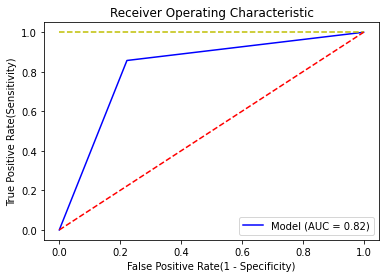

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def inference (model, test_dl):
  correct_prediction = 0
  total_prediction = 0
  TP = 0 
  TN = 0
  FN = 0
  FP = 0
  a = []
  b = []
  with torch.no_grad():
    for i, data in enumerate(test_dl):
      
      x, labels = data[0].to(device), data[2].to(device)
      cpu_labels = data[2]
      x_m, x_s = x.mean(), x.std()
      x = (x - x_m) / x_s
      outputs = model(x)
 
      _, prediction = torch.max(outputs,1)
      
      cpu_prediction = prediction.to('cpu')
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
          

      TP += ((prediction == 1) & (labels == 1)).sum()
# TN predict and label are both 0
      TN += ((prediction == 0) & (labels == 0)).sum()
# FN    predict 0 label 1
      FN += ((prediction == 0) & (labels == 1)).sum()
# FP    predict 1 label 0
      FP += ((prediction == 1) & (labels == 0)).sum()

      c = cpu_labels.tolist()
      a.extend(c)

      d = cpu_prediction.tolist()
      b.extend(d)
    
    # TP : 휘징인데 휘징이라고 판단(잘함)
    # FP : 헬시인데 휘징이라고 판단(못함)
    # TN : 헬시인데 헬시라고 판단(잘함)
    # FN : 휘징인데 헬시라고 판단(못함)
    
    # POSITIVE : 1(휘징)이라고 판단
    # NEGATIVE : 0(헬시)라고 판단
    # TRUE : 정답값 1(휘징)
    # FALSE : 정답값 0(헬시)
    
    # PRECISION : 휘징이라고 판단한 것 중 진짜 휘징
    # RECALL : 휘징인데 휘징이라고 잘 판단
    

  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  F1 = 2 * recall * precision / (recall + precision)
  print(TP)
  print(FP)
  print(FN)
  print(TN)

  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.4f}, Total items: {total_prediction}')
  print(f'precision: {precision:.4f}, F1: {F1:.4f}')
  print(f'recall: {recall:.4f}')
  target_names = ['healthy', 'wheezing']
  print(classification_report(a, b, target_names = target_names))
  print("AUC:{}".format(roc_auc_score(a, b)))
    
  plt.title('Receiver Operating Characteristic')
  plt.xlabel('False Positive Rate(1 - Specificity)')
  plt.ylabel('True Positive Rate(Sensitivity)')
  false_positive_rate, true_positive_rate, thresholds = roc_curve(a, b)
  roc_auc = metrics.roc_auc_score(a, b)
  plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model (AUC = %0.2f)'% roc_auc)
  plt.plot([0,1],[1,1],'y--')
  plt.plot([0,1],[0,1],'r--')

  plt.legend(loc='lower right')
  plt.show()


inference(Model1, test_dl)